## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

##  Section A: Implementation of the image processing pipeline
### Step 1. Compute the camera calibration using chessboard images

In [58]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.show()

# Calculate camera parameters and distortion coefficinets
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
assert ret, "Unsuccessful calibration! check images"
print(mtx)
print(dist)

[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41017956e-01  -5.30721172e-02  -1.15810355e-03  -1.28318857e-04
    2.67125292e-02]]


### Step 2. Apply a distortion correction to raw images

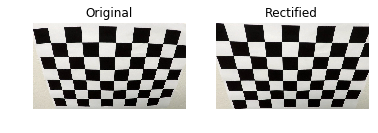

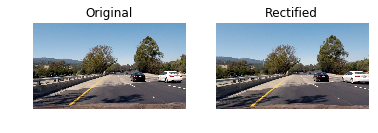

In [59]:
### Check an example chessboard image
img = cv2.imread('camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title("Rectified")
plt.axis('off')
plt.show()

### Check an lane line image
img = cv2.imread('test_images/test4.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title("Rectified")
plt.axis('off')
plt.show()

### Step 3. Use color transforms, gradients, etc., to create a thresholded binary image

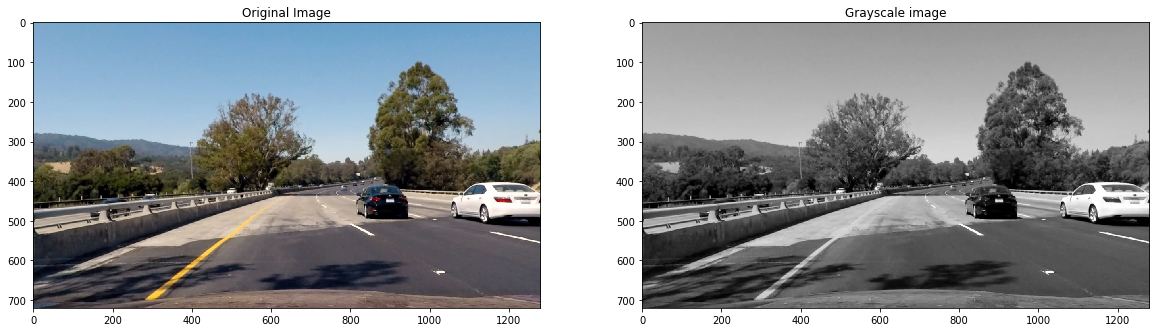

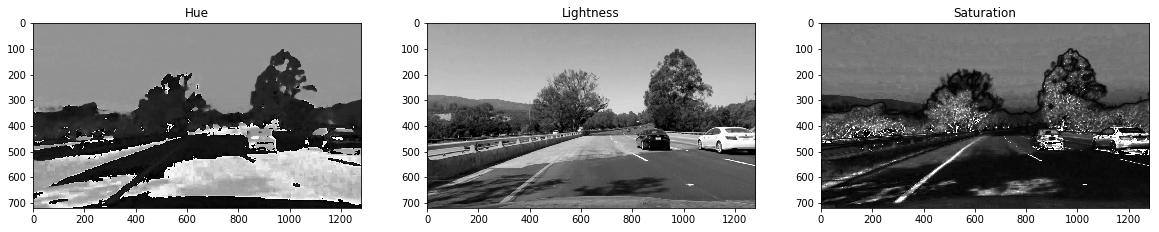

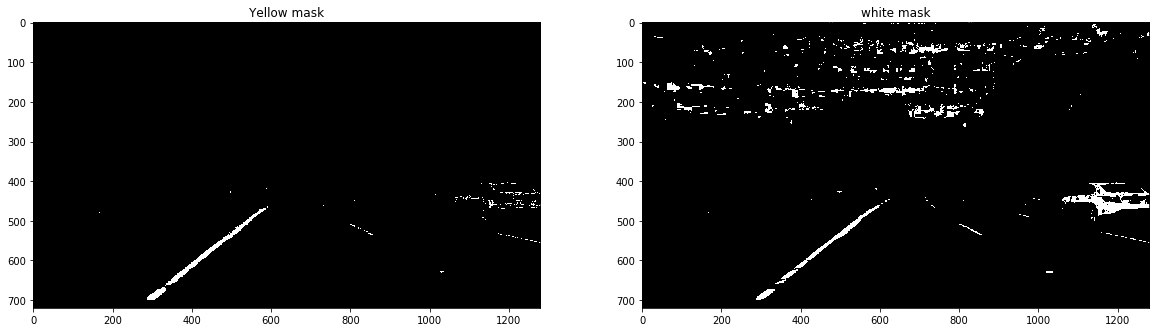

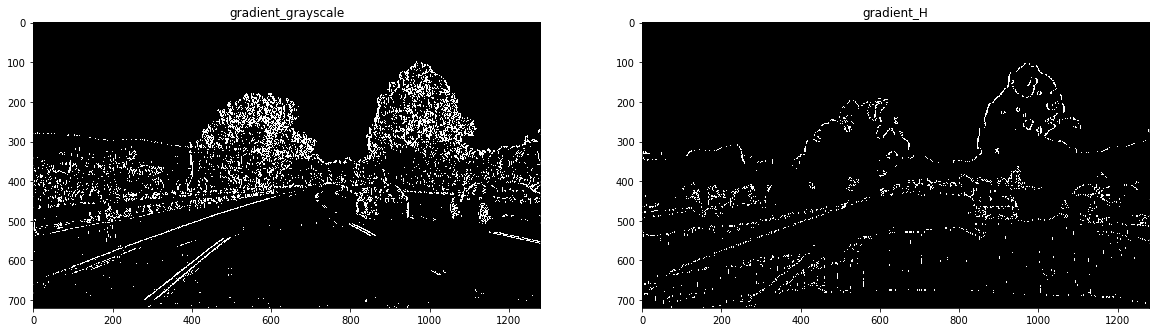

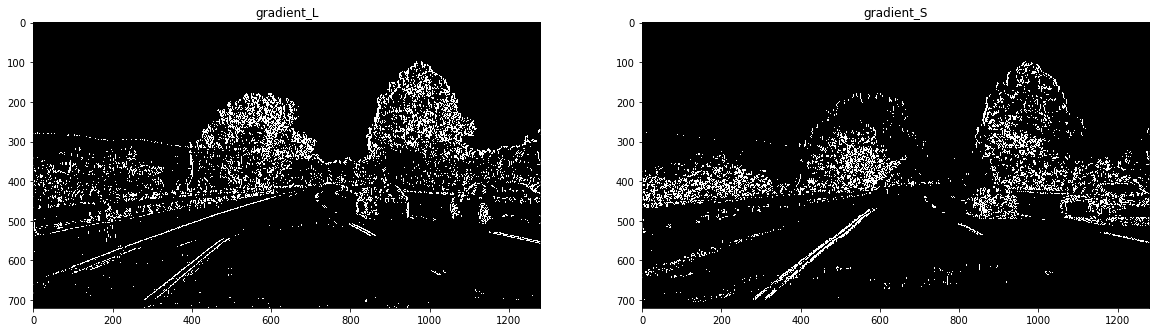

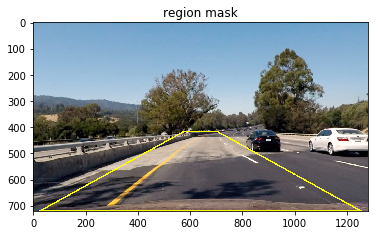

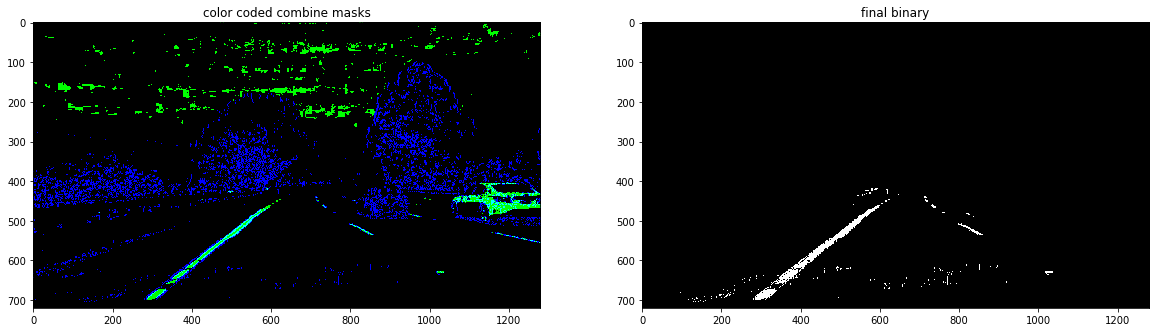

In [60]:
img = cv2.imread('test_images/test4.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax2.imshow(dst_gray, cmap = 'gray')
ax2.set_title('Grayscale image')

##============ Color space thresholding=============
img_HLS = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.set_title('Hue')
ax1.imshow(img_HLS[:, :, 0], cmap = 'gray')  #Hue
ax2.set_title('Lightness')
ax2.imshow(img_HLS[:, :, 1], cmap = 'gray')  #Lightness
ax3.set_title('Saturation')
ax3.imshow(img_HLS[:, :, 2], cmap = 'gray')  #Saturation

# Yellow mask
mask1 = cv2.inRange(img_HLS, (18, 100, 100), (23,255, 255))
# white mask
mask2 = cv2.inRange(img_HLS, (0, 125, 125), (255,255, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(mask1, cmap = 'gray')
ax1.set_title('Yellow mask')
ax2.imshow(mask2, cmap = 'gray')
ax2.set_title('white mask')

##============Gradient (on grayscale, H, L, S)===============
def sobelx_mask(img, th_min, th_max):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= th_min) & (scaled_sobel <= th_max)] = 1
    return sxbinary
gradient_grayscale = sobelx_mask(dst_gray, 20, 100)
gradient_H = sobelx_mask(img_HLS[:, :, 0], 20, 100)
gradient_L = sobelx_mask(img_HLS[:, :, 1], 20, 100)
gradient_S = sobelx_mask(img_HLS[:, :, 2], 20, 100)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(gradient_grayscale, cmap = 'gray')
ax1.set_title('gradient_grayscale')
ax2.imshow(gradient_H, cmap = 'gray')
ax2.set_title('gradient_H')
plt.show()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(gradient_L, cmap = 'gray')
ax1.set_title('gradient_L')
ax2.imshow(gradient_S, cmap = 'gray')
ax2.set_title('gradient_S')
plt.show()

##============region mask========================
[d1, d2, d3] = img.shape 
left_bottom = (int(d2*0.02), d1)
right_bottom = (int(d2*0.98), d1)
left_top = (int(d2*0.45), int(d1*0.58))
right_top = (int(d2*0.55), int(d1*0.58))

vertices = np.array([left_bottom, right_bottom, right_top, left_top])
region_mask = np.zeros_like(dst_gray)
cv2.fillPoly(region_mask, [vertices], 1)
# plt.imshow(region_mask, cmap = 'gray')
# plt.show()
dispImg = dst.copy()
cv2.polylines(dispImg, [vertices], True, (0, 255, 255), 3)
plt.imshow(cv2.cvtColor(dispImg, cv2.COLOR_BGR2RGB))
plt.title('region mask')
plt.show()

##==========final combined binary image============
combined_binary = np.zeros_like(dst_gray)
combined_binary[((mask2 == 255) | (gradient_S ==1)) & (region_mask == 1)] = 1
color_binary = np.dstack(( np.zeros_like(dst_gray), mask2==255, gradient_S)) * 255
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(color_binary)
ax1.set_title('color coded combine masks')
ax2.imshow(combined_binary, cmap = 'gray')
ax2.set_title('final binary')
plt.show()

### Step 4. Apply a perspective transform to rectify binary image ("birds-eye view").

[[ -5.57882490e-01  -1.52968005e+00   9.94292030e+02]
 [  9.99200722e-16  -1.83478767e+00   8.29988365e+02]
 [  2.60208521e-18  -2.39674229e-03   1.00000000e+00]]
[[  1.50919467e-01  -8.33709575e-01   5.41911224e+02]
 [ -1.13242749e-14  -5.45022194e-01   4.52362080e+02]
 [ -1.95156391e-17  -1.30627774e-03   1.00000000e+00]]


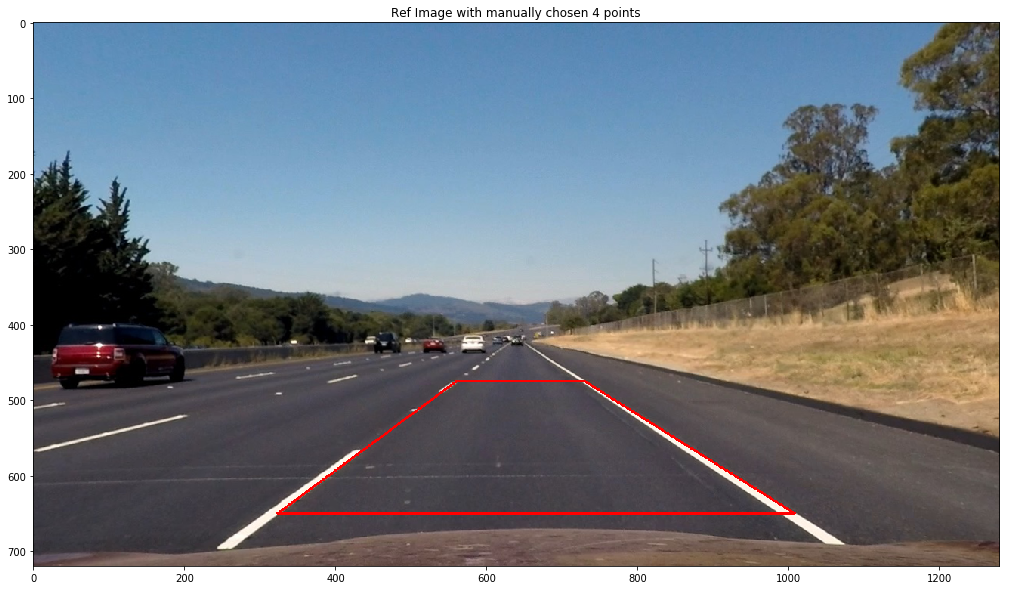

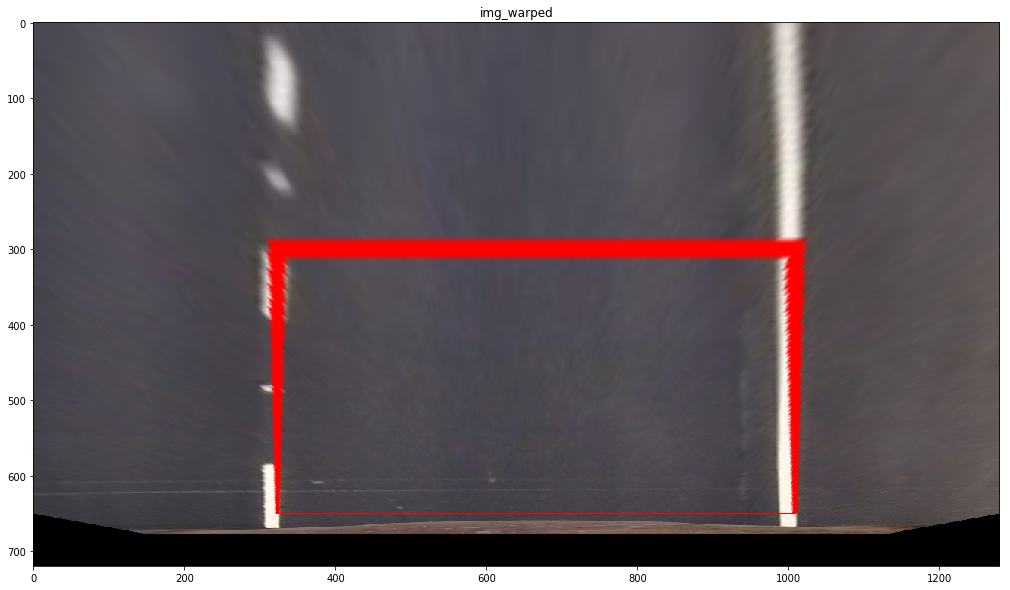

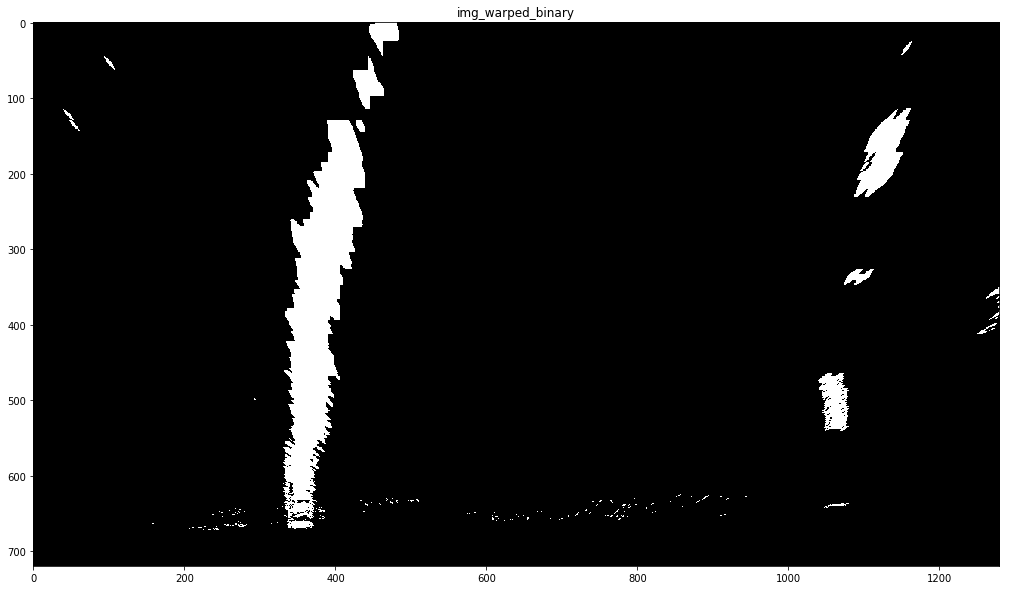

In [61]:
## Load an image with straight lines as reference for calculating perspective transform matrix
img_straightline = cv2.imread('test_images/straight_lines2.jpg')
img_straightline = cv2.undistort(img_straightline, mtx, dist, None, mtx)

# plt.imshow(cv2.cvtColor(img_straightline, cv2.COLOR_BGR2RGB))
# plt.title('Ref Image with straight lines')

pts = np.array([[323, 650], [1008, 650], [730, 475], [560, 475]])  #points manually picked from the image
dispImg = img_straightline.copy()
cv2.polylines(dispImg, [pts], True, (0, 0, 255), 2)
plt.figure(figsize = (20, 10))
plt.imshow(cv2.cvtColor(dispImg, cv2.COLOR_BGR2RGB))
plt.title('Ref Image with manually chosen 4 points')
pts = np.float32(pts)
pts_topdown = np.array([[323, 650], [1008, 650], [1008, 300], [323, 300]], dtype = np.float32)
M = cv2.getPerspectiveTransform(pts, pts_topdown)
Minv = cv2.getPerspectiveTransform(pts_topdown, pts)
print(M)
print(Minv)
#img_warped = cv2.warpPerspective(img_straightline, M, (img_straightline.shape[1], img_straightline.shape[0]), flags=cv2.INTER_LINEAR)
img_warped = cv2.warpPerspective(dispImg, M, (img_straightline.shape[1], img_straightline.shape[0]), flags=cv2.INTER_LINEAR)
plt.figure(figsize = (20, 10))
plt.imshow(cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB))
plt.title('img_warped')

## Birds eye on binary image from previous step
img_warped_binary = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
plt.figure(figsize = (20, 10))
plt.imshow(img_warped_binary, cmap = 'gray')
plt.title('img_warped_binary')

### Step 5. Detect lane pixels and fit to find the lane boundary.

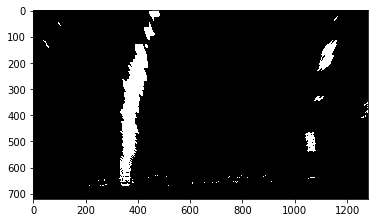

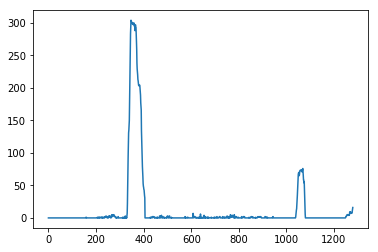

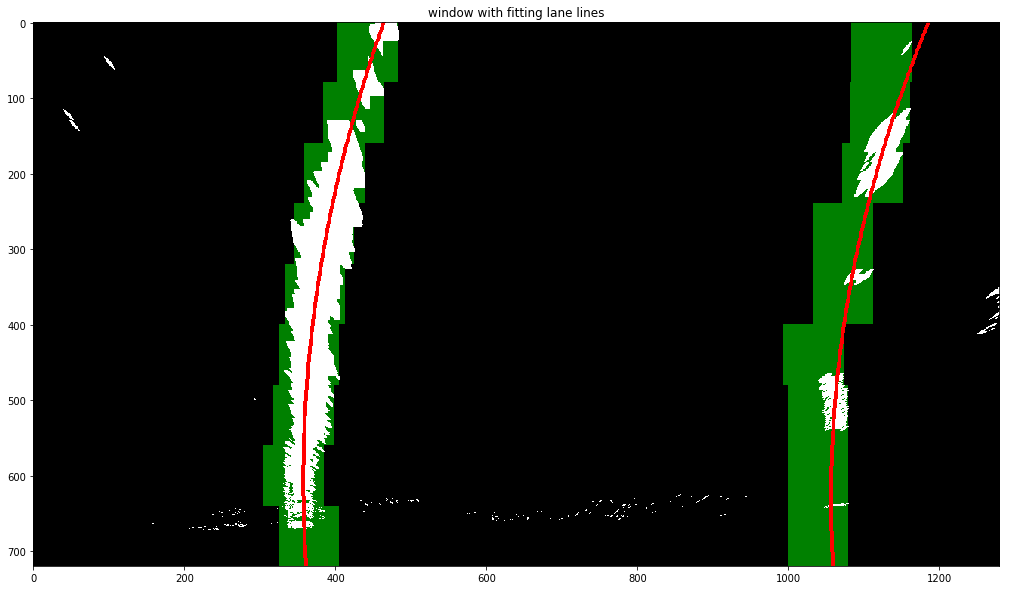

In [62]:
## Use bottom half image's histogram peaks as starting points for lane lines
bottom_half = img_warped_binary[int(img_warped_binary.shape[0]/2):, :]
histogram = np.sum(bottom_half, axis = 0)
plt.imshow(img_warped_binary, cmap = 'gray')
plt.show()
plt.plot(histogram)
plt.show()

## searching lanes using sliding windows (convolution with kernels), the functions were from Udacity's lecture
# window settings
window_width = 80 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum bottom half of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(2*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(2*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        conv_result = conv_signal[l_min_index:l_max_index]        
        #print('max left conv =%d'%np.max(conv_result))
        if np.max(conv_result) > 50:  #only update the center position if seeing enough pixels
            l_center = np.argmax(conv_result)+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        conv_result = conv_signal[r_min_index:r_max_index]
        #print('max right conv = %d'%np.max(conv_result))
        if np.max(conv_result) > 50:
            r_center = np.argmax(conv_result)+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(img_warped_binary, window_width, window_height, margin)
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output
# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(img_warped_binary)
    r_points = np.zeros_like(img_warped_binary)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,img_warped_binary,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,img_warped_binary,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((img_warped_binary, img_warped_binary, img_warped_binary))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # fit poly lines to left and right lane line=====
    l_lane = np.zeros_like(img_warped_binary)
    l_lane[(l_points==255)&(img_warped_binary==1)]=1    
    lane_dots = cv2.findNonZero(l_lane)    
    fit_left = np.polyfit(lane_dots[:,0, 1], lane_dots[:,0, 0], 2)  #note: fit y-> x
    r_lane = np.zeros_like(img_warped_binary)
    r_lane[(r_points==255)&(img_warped_binary==1)]=1    
    lane_dots = cv2.findNonZero(r_lane)    
    fit_right = np.polyfit(lane_dots[:,0, 1], lane_dots[:,0, 0], 2)  #note: fit y-> x
    
## If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the windows found with fitted polynomial lines
y = np.linspace(0, img_warped_binary.shape[0]-1, img_warped_binary.shape[0])
xfit_left = fit_left[0]*y**2+fit_left[1]*y+fit_left[2]
xfit_right = fit_right[0]*y**2+fit_right[1]*y+fit_right[2]
cv2.polylines(output, [np.vstack((xfit_left.astype(int),y.astype(int))).T], 0, (255, 0, 0), 3)
cv2.polylines(output, [np.vstack((xfit_right.astype(int),y.astype(int))).T], 0, (255, 0, 0), 3)

# pts = np.hstack(([np.vstack((xfit_left.astype(int),y.astype(int))).T], np.fliplr([np.vstack((xfit_right.astype(int),y.astype(int))).T])))
# cv2.fillPoly(output, np.int_([pts]), (0,255, 0))

plt.figure(figsize = (20, 10))
plt.imshow(output)
plt.title('window with fitting lane lines')
plt.show()

### Step 6. Determine the curvature of the lane and vehicle position with respect to center.

In [63]:
# convert pixels back to meters 
# Define conversions in x and y from pixels space to meters
# Note: This is assumed value (vertically 30 meter, horizontally lane is 3.7 meter wide, in real applications they need to be calibrated!
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Translate fitted equation (in pixels) to real world metrics (meters)
# original equation: x = A[0]*y**2 + A[1]*y+A[2]
# in real world metrics x/xm_per_pix = (A[0]*(y/ym_per_pix)**2+A[1]*(y/ym_per_pix)+A[2]
#curvature from fitted coeffients
fit_left_meter = np.array([fit_left[0]/(ym_per_pix**2)*xm_per_pix, fit_left[1]/ym_per_pix**2*xm_per_pix, fit_left[2]*xm_per_pix])
fit_right_meter = np.array([fit_right[0]/(ym_per_pix**2)*xm_per_pix, fit_right[1]/ym_per_pix**2*xm_per_pix, fit_right[2]*xm_per_pix])
#calculate curvature at bottom of image (current vehicle y position)
y_meter = y[-1]*ym_per_pix
current_curvature_left = (1+(2*fit_left_meter[0]*y_meter+fit_left_meter[1])**2)**1.5/np.absolute(2*fit_left_meter[0])
current_curvature_right = (1+(2*fit_right_meter[0]*y_meter+fit_right_meter[1])**2)**1.5/np.absolute(2*fit_right_meter[0])
#calculate vehicle position in x, with respect to center of lane
lane_center_deviation = (img_warped_binary.shape[1]/2-(xfit_left[-1]+xfit_right[-1])/2)*xm_per_pix

print('Left curvature/right curvature/center deviation (meter)')
print('%.2f / %.2f / %.2f'%(current_curvature_left, current_curvature_right, lane_center_deviation))

Left curvature/right curvature/center deviation (meter)
1642.32 / 1889.37 / -0.37


### Step 7. Warp the detected lane boundaries back onto the original image.

In [64]:
fitted_lane_boundary = np.zeros_like(img_warped)
line_width = int(0.2/xm_per_pix) #use line width of 20 mm
cv2.polylines(fitted_lane_boundary, [np.vstack((xfit_left.astype(int),y.astype(int))).T], 0, (0, 0, 255), line_width)
cv2.polylines(fitted_lane_boundary, [np.vstack((xfit_right.astype(int),y.astype(int))).T], 0, (0, 0, 255), line_width)
# plt.imshow(fitted_lane_boundary)

#warp back to original perspective
lane_origin_view = cv2.warpPerspective(fitted_lane_boundary, Minv, (dst.shape[1], dst.shape[0]), flags=cv2.INTER_LINEAR)


### Step 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

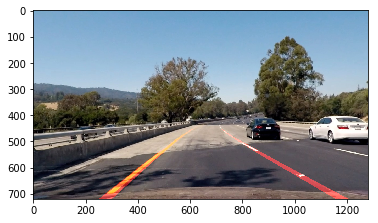

Left lane curvature (m): 1642.32
Right lane curvature (m): 1889.37
Vehicle position to lane center (m): -0.37


In [65]:
dispImg = cv2.addWeighted(dst, 1, lane_origin_view, 0.5, 0)
plt.imshow(cv2.cvtColor(dispImg, cv2.COLOR_BGR2RGB))
plt.show()
print('Left lane curvature (m): %.2f'%current_curvature_left)
print('Right lane curvature (m): %.2f'%current_curvature_right)
print('Vehicle position to lane center (m): %.2f'%lane_center_deviation)

----
## Section B: Processing example videos through the pipeline.

In [66]:
## This section is for testing only, NOT used in later video processing
## Encapsulate some code above into functions

def getThresholdLaneImg(img):
    img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # # Yellow mask
    # mask1 = cv2.inRange(img_HLS, (18, 100, 100), (23,255, 255))
    # white mask
    mask2 = cv2.inRange(img_HLS, (0, 125, 125), (255,255, 255))
    ##============Gradient (on S)===============
    gradient_S = sobelx_mask(img_HLS[:, :, 2], 20, 100)
    ##============region mask========================
    [d1, d2, d3] = img.shape 
    left_bottom = (int(d2*0.05), d1)
    right_bottom = (int(d2*0.95), d1)
    left_top = (int(d2*0.48), int(d1*0.58))
    right_top = (int(d2*0.52), int(d1*0.58))
    vertices = np.array([left_bottom, right_bottom, right_top, left_top])
    region_mask = np.zeros_like(dst_gray)
    cv2.fillPoly(region_mask, [vertices], 1)
    ##==========final combined binary image============
    combined_binary = np.zeros_like(dst_gray)
    combined_binary[((mask2 == 255) | (gradient_S ==1)) & (region_mask == 1)] = 1
    return combined_binary

def findLaneLinesWithSlidingWindow(img_warped_binary, window_width=80, window_height=80, margin=100):
    window_centroids = find_window_centroids(img_warped_binary, window_width, window_height, margin)
    fit_left = []
    fit_right = []
    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img_warped_binary)
        r_points = np.zeros_like(img_warped_binary)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img_warped_binary,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,img_warped_binary,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((img_warped_binary, img_warped_binary, img_warped_binary))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        # fit poly lines to left and right lane line=====
        l_lane = np.zeros_like(img_warped_binary)
        l_lane[(l_points==255)&(img_warped_binary==1)]=1    
        lane_dots = cv2.findNonZero(l_lane)
        if lane_dots is not None:
            fit_left = np.polyfit(lane_dots[:,0, 1], lane_dots[:,0, 0], 2)  #note: fit y-> x
        r_lane = np.zeros_like(img_warped_binary)
        r_lane[(r_points==255)&(img_warped_binary==1)]=1    
        lane_dots = cv2.findNonZero(r_lane)    
        if lane_dots is not None:
            fit_right = np.polyfit(lane_dots[:,0, 1], lane_dots[:,0, 0], 2)  #note: fit y-> x

    ## If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output, fit_left, fit_right  #output is the pixels found for left and right lane
def calcRadiusCurvature(fit_left, fit_right, xm_per_pix, ym_per_pix):
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Translate fitted equation (in pixels) to real world metrics (meters)
    # original equation: x = A[0]*y**2 + A[1]*y+A[2]
    # in real world metrics x/xm_per_pix = (A[0]*(y/ym_per_pix)**2+A[1]*(y/ym_per_pix)+A[2]
    
    #calculate curvature at bottom of image (current vehicle y position)
    #y_meter = y[-1]*ym_per_pix
    y_meter = 720*ym_per_pix
    #curvature from fitted coeffients
    if len(fit_left)>0:
        fit_left_meter = np.array([fit_left[0]/(ym_per_pix**2)*xm_per_pix, fit_left[1]/ym_per_pix**2*xm_per_pix, fit_left[2]*xm_per_pix])
        current_curvature_left = (1+(2*fit_left_meter[0]*y_meter+fit_left_meter[1])**2)**1.5/np.absolute(2*fit_left_meter[0])
    else:
        fit_left_meter = []
        current_curvature_left = []
    if len(fit_right)>0:
        fit_right_meter = np.array([fit_right[0]/(ym_per_pix**2)*xm_per_pix, fit_right[1]/ym_per_pix**2*xm_per_pix, fit_right[2]*xm_per_pix])
        current_curvature_right = (1+(2*fit_right_meter[0]*y_meter+fit_right_meter[1])**2)**1.5/np.absolute(2*fit_right_meter[0])
    else:
        fit_right_meter = []
        current_curvature_right = []
    return current_curvature_left, current_curvature_right
def drawFittedLaneInOriginalView(dst, img_warped, Minv, fit_left, fit_right, xm_per_pix=3.7/700):
    y = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
    fitted_lane_boundary = np.zeros_like(img_warped)
    line_width = int(0.2/xm_per_pix) #use line width of 20 mm
    
    ##====draw the lane lines
    if len(fit_left)>0:
        xfit_left = fit_left[0]*y**2+fit_left[1]*y+fit_left[2]
        pts_left = np.array([np.vstack((xfit_left.astype(int),y.astype(int))).T])
        cv2.polylines(fitted_lane_boundary, pts_left, 0, (0, 0, 255), line_width)
    if len(fit_right)>0:
        xfit_right = fit_right[0]*y**2+fit_right[1]*y+fit_right[2]
        pts_right = np.array([np.vstack((xfit_right.astype(int),y.astype(int))).T])
        cv2.polylines(fitted_lane_boundary, pts_right, 0, (0, 0, 255), line_width)
    ##==== fill in the lane area
    if len(fit_left)>0 and len(fit_right)>0:
        pts = np.hstack((pts_left, np.fliplr(pts_right)))
        cv2.fillPoly(fitted_lane_boundary, np.int_([pts]), (0,255, 0))
    #warp back to original perspective
    lane_origin_view = cv2.warpPerspective(fitted_lane_boundary, Minv, (dst.shape[1], dst.shape[0]), flags=cv2.INTER_LINEAR)
    dispImg = cv2.addWeighted(dst, 1, lane_origin_view, 0.5, 0)
    return dispImg

# ##===========main function to process each frame===============
# def process_image(img):
#     mtx = np.array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
#              [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
#              [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
#     dist = np.array([[ -2.41017956e-01,  -5.30721172e-02,  -1.15810355e-03,  -1.28318857e-04,  2.67125292e-02]])
#     dst = cv2.undistort(img, mtx, dist, None, mtx)
#     combined_binary = getThresholdLaneImg(dst)
#     M = np.array([[ -5.57882490e-01,  -1.52968005e+00,   9.94292030e+02],
#          [  9.99200722e-16,  -1.83478767e+00,   8.29988365e+02],
#          [  2.60208521e-18,  -2.39674229e-03,   1.00000000e+00]])
#     Minv = np.array([[  1.50919467e-01,  -8.33709575e-01,   5.41911224e+02],
#              [ -1.13242749e-14,  -5.45022194e-01,   4.52362080e+02],
#              [ -1.95156391e-17,  -1.30627774e-03,   1.00000000e+00]])
#     img_warped_binary = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
#     img_lane_binary, fit_left, fit_right = findLaneLinesWithSlidingWindow(img_warped_binary, window_width, window_height, margin)
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
#     current_curvature_left, current_curvature_right = calcRadiusCurvature(fit_left, fit_right, xm_per_pix, ym_per_pix)
#     #calculate vehicle position in x, with respect to center of lane
#     lane_center_deviation = (img_warped_binary.shape[1]/2-(xfit_left[-1]+xfit_right[-1])/2)*xm_per_pix
#     dispImg = drawFittedLaneInOriginalView(dst, img_warped, Minv, fit_left, fit_right)
#     return dispImg

In [78]:
##============= class implementation =====================
class LaneDetector:
    lane_center_deviation_history = []
    curvature_left_history = []
    curvature_right_history = []
    fit_left_history = []
    fit_right_history = []
    ## camera parameters and distortion coefficients
    mtx = np.array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
                 [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
                 [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
    dist = np.array([[ -2.41017956e-01,  -5.30721172e-02,  -1.15810355e-03,  -1.28318857e-04,  2.67125292e-02]])
    ## Perspective transform parameters
    M = np.array([[ -5.57882490e-01,  -1.52968005e+00,   9.94292030e+02],
             [  9.99200722e-16,  -1.83478767e+00,   8.29988365e+02],
             [  2.60208521e-18,  -2.39674229e-03,   1.00000000e+00]])
    Minv = np.array([[  1.50919467e-01,  -8.33709575e-01,   5.41911224e+02],
             [ -1.13242749e-14,  -5.45022194e-01,   4.52362080e+02],
             [ -1.95156391e-17,  -1.30627774e-03,   1.00000000e+00]])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension  
    image = []
    failureCnt = 0  #counter of failure to find valid lane lines, reset after 2 (0->1->2)
    def __init__(self):
        self.lane_center_deviation_history = []
        self.curvature_left_history = []
        self.curvature_right_history = []
    def __call__(self, img):   ## This is the main function of processing frames 
        self.image = img
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        combined_binary = self.getThresholdLaneImg(dst)        
        img_warped_binary = cv2.warpPerspective(combined_binary, self.M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
        if (self.fit_left_history==[]) or self.failureCnt>2: #first frame, use sliding window search
            img_lane_binary, fit_left, fit_right = self.findLaneLinesWithSlidingWindow(img_warped_binary, window_width, window_height, margin)
            self.failureCnt = 0
        else: ## following frames use previous fitting area to search for lane markings
            img_lane_binary, fit_left, fit_right = self.findLaneLinesWithPreviousPolyfit(img_warped_binary)
        fit_left, fit_right = self.sanityCheckLaneLines(fit_left, fit_right) 
        current_curvature_left, current_curvature_right = self.calcRadiusCurvature(fit_left, fit_right, self.xm_per_pix, self.ym_per_pix)
        #calculate vehicle position in x, with respect to center of lane 
        y = img_warped_binary.shape[0]
        xfit_left = fit_left[0]*y**2+fit_left[1]*y+fit_left[2]
        xfit_right = fit_right[0]*y**2+fit_right[1]*y+fit_right[2]
        lane_center_deviation = (img_warped_binary.shape[1]/2-(xfit_left+xfit_right)/2)*xm_per_pix
        dispImg = self.drawFittedLaneInOriginalView(dst, img_warped, self.Minv, fit_left, fit_right) 
        
        self.lane_center_deviation_history.append(lane_center_deviation)
        self.curvature_left_history.append(current_curvature_left)
        self.curvature_right_history.append(current_curvature_right)
        self.fit_left_history.append(fit_left)
        self.fit_right_history.append(fit_right)
        return dispImg
    def getThresholdLaneImg(self, img):
        img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        # # Yellow mask
        # mask1 = cv2.inRange(img_HLS, (18, 100, 100), (23,255, 255))
        # white mask
        mask2 = cv2.inRange(img_HLS, (0, 125, 125), (255,255, 255))
        ##============Gradient (on S)===============
        gradient_S = sobelx_mask(img_HLS[:, :, 2], 20, 100)
        ##============region mask========================
        [d1, d2, d3] = img.shape 
        left_bottom = (int(d2*0.03), d1)
        right_bottom = (int(d2*0.97), d1)
        left_top = (int(d2*0.45), int(d1*0.58))
        right_top = (int(d2*0.55), int(d1*0.58))
        vertices = np.array([left_bottom, right_bottom, right_top, left_top])
        region_mask = np.zeros_like(dst_gray)
        cv2.fillPoly(region_mask, [vertices], 1)
        ##==========final combined binary image============
        combined_binary = np.zeros_like(dst_gray)
        combined_binary[((mask2 == 255) | (gradient_S ==1)) & (region_mask == 1)] = 1
        return combined_binary

    def findLaneLinesWithSlidingWindow(self, img_warped_binary, window_width=80, window_height=80, margin=100):
        window_centroids = find_window_centroids(img_warped_binary, window_width, window_height, margin)
        fit_left = []
        fit_right = []
        # If we found any window centers
        if len(window_centroids) > 0:
            # Points used to draw all the left and right windows
            l_points = np.zeros_like(img_warped_binary)
            r_points = np.zeros_like(img_warped_binary)

            # Go through each level and draw the windows 	
            for level in range(0,len(window_centroids)):
                # Window_mask is a function to draw window areas
                l_mask = window_mask(window_width,window_height,img_warped_binary,window_centroids[level][0],level)
                r_mask = window_mask(window_width,window_height,img_warped_binary,window_centroids[level][1],level)
                # Add graphic points from window mask here to total pixels found 
                l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
                r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

            # Draw the results
            template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
            zero_channel = np.zeros_like(template) # create a zero color channel
            template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
            warpage= np.dstack((img_warped_binary, img_warped_binary, img_warped_binary))*255 # making the original road pixels 3 color channels
            output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
            # fit poly lines to left and right lane line=====
            l_lane = np.zeros_like(img_warped_binary)
            l_lane[(l_points==255)&(img_warped_binary==1)]=1    
            lane_dots = cv2.findNonZero(l_lane)
            if lane_dots is not None:
                fit_left = np.polyfit(lane_dots[:,0, 1], lane_dots[:,0, 0], 2)  #note: fit y-> x
            r_lane = np.zeros_like(img_warped_binary)
            r_lane[(r_points==255)&(img_warped_binary==1)]=1    
            lane_dots = cv2.findNonZero(r_lane)    
            if lane_dots is not None:
                fit_right = np.polyfit(lane_dots[:,0, 1], lane_dots[:,0, 0], 2)  #note: fit y-> x

        ## If no window centers found, just display orginal road image
        else:
            output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        return output, fit_left, fit_right  #output is the pixels found for left and right lane
    
    def findLaneLinesWithPreviousPolyfit(self, img_warped_binary, margin = 80):
        y = np.linspace(0, img_warped_binary.shape[0]-1, img_warped_binary.shape[0])
        last_fit_left = self.fit_left_history[-1]        
        xfit_left = last_fit_left[0]*y**2+last_fit_left[1]*y+last_fit_left[2]
        pts_left1 = np.vstack((xfit_left.astype(int)-margin,y.astype(int))).T
        pts_left2 = np.vstack((xfit_left.astype(int)+margin,y.astype(int))).T
        vertices = np.vstack((pts_left1, np.flipud(pts_left2)))        
        l_mask = np.zeros_like(img_warped_binary)        
        cv2.fillPoly(l_mask, [vertices], 255)
        
        last_fit_right = self.fit_right_history[-1]
        xfit_right = last_fit_right[0]*y**2+last_fit_right[1]*y+last_fit_right[2]
        pts_right1 = np.vstack((xfit_right.astype(int)-margin,y.astype(int))).T
        pts_right2 = np.vstack((xfit_right.astype(int)+margin,y.astype(int))).T
        vertices = np.vstack((pts_right1, np.flipud(pts_right2)))        
        r_mask = np.zeros_like(img_warped_binary)
        cv2.fillPoly(r_mask, [vertices], 255)

        # Draw the mask
        template = np.array(l_mask+r_mask,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((img_warped_binary, img_warped_binary, img_warped_binary))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        
        # fit poly lines to left and right lane line=====
        fit_left = []
        fit_right = []        
        l_lane = np.zeros_like(img_warped_binary)
        l_lane[(l_mask==255)&(img_warped_binary==1)]=1    
        lane_dots = cv2.findNonZero(l_lane)
        if lane_dots is not None:
            fit_left = np.polyfit(lane_dots[:,0, 1], lane_dots[:,0, 0], 2)  #note: fit y-> x
        r_lane = np.zeros_like(img_warped_binary)
        r_lane[(r_mask==255)&(img_warped_binary==1)]=1    
        lane_dots = cv2.findNonZero(r_lane)    
        if lane_dots is not None:
            fit_right = np.polyfit(lane_dots[:,0, 1], lane_dots[:,0, 0], 2)  #note: fit y-> x
                
        return output, fit_left, fit_right  #output is the pixels found for left and right lane
    def sanityCheckLaneLines(self, fit_left, fit_right):        
        ## check if fitting results is empty
        if (fit_left == []) or (fit_right == []):            
            if fit_left == []:
                fit_left = self.fit_left_history[-1]             
            if fit_right == []:
                fit_right = self.fit_right_history[-1]
            self.failureCnt += 1
            return fit_left, fit_right
        ## if the distance between the two fitted lane lines deviates from ~3.7m        
        y = np.linspace(0, self.image.shape[0]-1, self.image.shape[0])
        xfit_left = fit_left[0]*y**2+fit_left[1]*y+fit_left[2]
        xfit_right = fit_right[0]*y**2+fit_right[1]*y+fit_right[2]
        distance = (xfit_right-xfit_left)*self.xm_per_pix
        if (np.min(distance)<3) or (np.min(distance)>4.5):  ## reject if distance less than 3 meter or greater than 4.5 meter
            fit_left = self.fit_left_history[-1]
            fit_right = self.fit_right_history[-1]
            self.failureCnt += 1
        return fit_left, fit_right    
    def calcRadiusCurvature(self, fit_left, fit_right, xm_per_pix, ym_per_pix):
    #     ym_per_pix = 30/720 # meters per pixel in y dimension
    #     xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Translate fitted equation (in pixels) to real world metrics (meters)
        # original equation: x = A[0]*y**2 + A[1]*y+A[2]
        # in real world metrics x/xm_per_pix = (A[0]*(y/ym_per_pix)**2+A[1]*(y/ym_per_pix)+A[2]

        #calculate curvature at bottom of image (current vehicle y position)
        #y_meter = y[-1]*ym_per_pix
        y_meter = 720*ym_per_pix
        #curvature from fitted coeffients
        if len(fit_left)>0:
            fit_left_meter = np.array([fit_left[0]/(ym_per_pix**2)*xm_per_pix, fit_left[1]/ym_per_pix**2*xm_per_pix, fit_left[2]*xm_per_pix])
            current_curvature_left = (1+(2*fit_left_meter[0]*y_meter+fit_left_meter[1])**2)**1.5/np.absolute(2*fit_left_meter[0])
        else:
            fit_left_meter = []
            current_curvature_left = []
        if len(fit_right)>0:
            fit_right_meter = np.array([fit_right[0]/(ym_per_pix**2)*xm_per_pix, fit_right[1]/ym_per_pix**2*xm_per_pix, fit_right[2]*xm_per_pix])
            current_curvature_right = (1+(2*fit_right_meter[0]*y_meter+fit_right_meter[1])**2)**1.5/np.absolute(2*fit_right_meter[0])
        else:
            fit_right_meter = []
            current_curvature_right = []
        return current_curvature_left, current_curvature_right
    def drawFittedLaneInOriginalView(self, dst, img_warped, Minv, fit_left, fit_right, xm_per_pix=3.7/700):
        y = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
        fitted_lane_boundary = np.zeros_like(img_warped)
        line_width = int(0.2/xm_per_pix) #use line width of 20 mm

        ##====draw the lane lines
        if len(fit_left)>0:
            xfit_left = fit_left[0]*y**2+fit_left[1]*y+fit_left[2]
            pts_left = np.array([np.vstack((xfit_left.astype(int),y.astype(int))).T])
            cv2.polylines(fitted_lane_boundary, pts_left, 0, (0, 0, 255), line_width)
        if len(fit_right)>0:
            xfit_right = fit_right[0]*y**2+fit_right[1]*y+fit_right[2]
            pts_right = np.array([np.vstack((xfit_right.astype(int),y.astype(int))).T])
            cv2.polylines(fitted_lane_boundary, pts_right, 0, (0, 0, 255), line_width)
        ##==== fill in the lane area
        if len(fit_left)>0 and len(fit_right)>0:
            pts = np.hstack((pts_left, np.fliplr(pts_right)))
            cv2.fillPoly(fitted_lane_boundary, np.int_([pts]), (0,255, 0))
        #warp back to original perspective
        lane_origin_view = cv2.warpPerspective(fitted_lane_boundary, Minv, (dst.shape[1], dst.shape[0]), flags=cv2.INTER_LINEAR)
        dispImg = cv2.addWeighted(dst, 1, lane_origin_view, 0.5, 0)
        return dispImg  

### Video 1 - project_video.mp4

In [79]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_path = 'output_videos/project_video(output).mp4'
original_clip = VideoFileClip("project_video.mp4")
#output_clip = original_clip.fl_image(process_image)
myLaneDetector = LaneDetector()  #initialize an object, in this case its __init__() is called
output_clip = original_clip.fl_image(myLaneDetector)  #call object by name, in this case its __call__() is called

%time output_clip.write_videofile(output_path, audio=False, verbose=False, progress_bar=True)



  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<03:35,  5.85it/s]

  0%|          | 2/1261 [00:00<03:29,  6.01it/s]

  0%|          | 3/1261 [00:00<03:31,  5.95it/s]

  0%|          | 4/1261 [00:00<03:28,  6.02it/s]

  0%|          | 5/1261 [00:00<03:35,  5.84it/s]

  0%|          | 6/1261 [00:01<03:38,  5.74it/s]

  1%|          | 7/1261 [00:01<03:36,  5.79it/s]

  1%|          | 8/1261 [00:01<03:44,  5.58it/s]

  1%|          | 9/1261 [00:01<03:51,  5.41it/s]

  1%|          | 10/1261 [00:01<03:55,  5.31it/s]

  1%|          | 11/1261 [00:02<03:56,  5.28it/s]

  1%|          | 12/1261 [00:02<04:00,  5.20it/s]

  1%|          | 13/1261 [00:02<03:56,  5.27it/s]

  1%|          | 14/1261 [00:02<03:53,  5.34it/s]

  1%|          | 15/1261 [00:02<03:52,  5.37it/s]

  1%|▏         | 16/1261 [00:02<03:52,  5.35it/s]

  1%|▏         | 17/1261 [00:03<03:57,  5.25it/s]

  1%|▏         | 18/1261 [00:03<03:56,  5.26it/s]

  2%|▏         | 19/1261 [00:03<03:54,  5.30it/

 11%|█▏        | 143/1261 [00:25<03:22,  5.53it/s]

 11%|█▏        | 144/1261 [00:26<03:22,  5.52it/s]

 11%|█▏        | 145/1261 [00:26<03:22,  5.51it/s]

 12%|█▏        | 146/1261 [00:26<03:22,  5.50it/s]

 12%|█▏        | 147/1261 [00:26<03:22,  5.49it/s]

 12%|█▏        | 148/1261 [00:26<03:22,  5.49it/s]

 12%|█▏        | 149/1261 [00:27<03:22,  5.48it/s]

 12%|█▏        | 150/1261 [00:27<03:22,  5.48it/s]

 12%|█▏        | 151/1261 [00:27<03:22,  5.47it/s]

 12%|█▏        | 152/1261 [00:27<03:22,  5.47it/s]

 12%|█▏        | 153/1261 [00:28<03:23,  5.46it/s]

 12%|█▏        | 154/1261 [00:28<03:23,  5.45it/s]

 12%|█▏        | 155/1261 [00:28<03:23,  5.44it/s]

 12%|█▏        | 156/1261 [00:28<03:23,  5.43it/s]

 12%|█▏        | 157/1261 [00:28<03:23,  5.42it/s]

 13%|█▎        | 158/1261 [00:29<03:23,  5.42it/s]

 13%|█▎        | 159/1261 [00:29<03:22,  5.43it/s]

 13%|█▎        | 160/1261 [00:29<03:22,  5.44it/s]

 13%|█▎        | 161/1261 [00:29<03:22,  5.44it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [00:50<02:53,  5.63it/s]

 23%|██▎       | 285/1261 [00:50<02:53,  5.63it/s]

 23%|██▎       | 286/1261 [00:50<02:53,  5.63it/s]

 23%|██▎       | 287/1261 [00:50<02:52,  5.63it/s]

 23%|██▎       | 288/1261 [00:51<02:52,  5.63it/s]

 23%|██▎       | 289/1261 [00:51<02:52,  5.64it/s]

 23%|██▎       | 290/1261 [00:51<02:52,  5.64it/s]

 23%|██▎       | 291/1261 [00:51<02:51,  5.65it/s]

 23%|██▎       | 292/1261 [00:51<02:51,  5.65it/s]

 23%|██▎       | 293/1261 [00:51<02:51,  5.65it/s]

 23%|██▎       | 294/1261 [00:52<02:51,  5.65it/s]

 23%|██▎       | 295/1261 [00:52<02:50,  5.65it/s]

 23%|██▎       | 296/1261 [00:52<02:50,  5.66it/s]

 24%|██▎       | 297/1261 [00:52<02:50,  5.66it/s]

 24%|██▎       | 298/1261 [00:52<02:50,  5.66it/s]

 24%|██▎       | 299/1261 [00:52<02:49,  5.67it/s]

 24%|██▍       | 300/1261 [00:52<02:49,  5.67it/s]

 24%|██▍       | 301/1261 [00:53<02:49,  5.67it/s]

 24%|██▍       | 302/1261 [00:53<02:49,  5.67it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [01:13<02:24,  5.78it/s]

 34%|███▍      | 426/1261 [01:13<02:24,  5.78it/s]

 34%|███▍      | 427/1261 [01:13<02:24,  5.78it/s]

 34%|███▍      | 428/1261 [01:13<02:23,  5.79it/s]

 34%|███▍      | 429/1261 [01:14<02:23,  5.79it/s]

 34%|███▍      | 430/1261 [01:14<02:23,  5.79it/s]

 34%|███▍      | 431/1261 [01:14<02:23,  5.79it/s]

 34%|███▍      | 432/1261 [01:14<02:23,  5.79it/s]

 34%|███▍      | 433/1261 [01:14<02:22,  5.80it/s]

 34%|███▍      | 434/1261 [01:14<02:22,  5.79it/s]

 34%|███▍      | 435/1261 [01:15<02:22,  5.80it/s]

 35%|███▍      | 436/1261 [01:15<02:22,  5.80it/s]

 35%|███▍      | 437/1261 [01:15<02:22,  5.80it/s]

 35%|███▍      | 438/1261 [01:15<02:21,  5.80it/s]

 35%|███▍      | 439/1261 [01:15<02:21,  5.80it/s]

 35%|███▍      | 440/1261 [01:15<02:21,  5.80it/s]

 35%|███▍      | 441/1261 [01:15<02:21,  5.80it/s]

 35%|███▌      | 442/1261 [01:16<02:21,  5.81it/s]

 35%|███▌      | 443/1261 [01:16<02:20,  5.81it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [01:36<01:58,  5.87it/s]

 45%|████▍     | 567/1261 [01:36<01:58,  5.87it/s]

 45%|████▌     | 568/1261 [01:36<01:58,  5.87it/s]

 45%|████▌     | 569/1261 [01:36<01:57,  5.87it/s]

 45%|████▌     | 570/1261 [01:37<01:57,  5.87it/s]

 45%|████▌     | 571/1261 [01:37<01:57,  5.87it/s]

 45%|████▌     | 572/1261 [01:37<01:57,  5.87it/s]

 45%|████▌     | 573/1261 [01:37<01:57,  5.87it/s]

 46%|████▌     | 574/1261 [01:37<01:56,  5.87it/s]

 46%|████▌     | 575/1261 [01:37<01:56,  5.88it/s]

 46%|████▌     | 576/1261 [01:38<01:56,  5.88it/s]

 46%|████▌     | 577/1261 [01:38<01:56,  5.88it/s]

 46%|████▌     | 578/1261 [01:38<01:56,  5.88it/s]

 46%|████▌     | 579/1261 [01:38<01:56,  5.88it/s]

 46%|████▌     | 580/1261 [01:38<01:55,  5.88it/s]

 46%|████▌     | 581/1261 [01:38<01:55,  5.88it/s]

 46%|████▌     | 582/1261 [01:39<01:55,  5.88it/s]

 46%|████▌     | 583/1261 [01:39<01:55,  5.88it/s]

 46%|████▋     | 584/1261 [01:39<01:55,  5.88it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [02:00<01:34,  5.89it/s]

 56%|█████▌    | 708/1261 [02:00<01:33,  5.89it/s]

 56%|█████▌    | 709/1261 [02:00<01:33,  5.89it/s]

 56%|█████▋    | 710/1261 [02:00<01:33,  5.89it/s]

 56%|█████▋    | 711/1261 [02:00<01:33,  5.89it/s]

 56%|█████▋    | 712/1261 [02:00<01:33,  5.89it/s]

 57%|█████▋    | 713/1261 [02:01<01:33,  5.89it/s]

 57%|█████▋    | 714/1261 [02:01<01:32,  5.89it/s]

 57%|█████▋    | 715/1261 [02:01<01:32,  5.89it/s]

 57%|█████▋    | 716/1261 [02:01<01:32,  5.89it/s]

 57%|█████▋    | 717/1261 [02:01<01:32,  5.89it/s]

 57%|█████▋    | 718/1261 [02:01<01:32,  5.89it/s]

 57%|█████▋    | 719/1261 [02:02<01:31,  5.89it/s]

 57%|█████▋    | 720/1261 [02:02<01:31,  5.89it/s]

 57%|█████▋    | 721/1261 [02:02<01:31,  5.89it/s]

 57%|█████▋    | 722/1261 [02:02<01:31,  5.89it/s]

 57%|█████▋    | 723/1261 [02:02<01:31,  5.89it/s]

 57%|█████▋    | 724/1261 [02:02<01:31,  5.89it/s]

 57%|█████▋    | 725/1261 [02:03<01:30,  5.89it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [02:23<01:09,  5.92it/s]

 67%|██████▋   | 849/1261 [02:23<01:09,  5.92it/s]

 67%|██████▋   | 850/1261 [02:23<01:09,  5.92it/s]

 67%|██████▋   | 851/1261 [02:23<01:09,  5.93it/s]

 68%|██████▊   | 852/1261 [02:23<01:09,  5.93it/s]

 68%|██████▊   | 853/1261 [02:23<01:08,  5.93it/s]

 68%|██████▊   | 854/1261 [02:24<01:08,  5.93it/s]

 68%|██████▊   | 855/1261 [02:24<01:08,  5.93it/s]

 68%|██████▊   | 856/1261 [02:24<01:08,  5.93it/s]

 68%|██████▊   | 857/1261 [02:24<01:08,  5.93it/s]

 68%|██████▊   | 858/1261 [02:24<01:08,  5.93it/s]

 68%|██████▊   | 859/1261 [02:24<01:07,  5.93it/s]

 68%|██████▊   | 860/1261 [02:25<01:07,  5.93it/s]

 68%|██████▊   | 861/1261 [02:25<01:07,  5.93it/s]

 68%|██████▊   | 862/1261 [02:25<01:07,  5.93it/s]

 68%|██████▊   | 863/1261 [02:25<01:07,  5.93it/s]

 69%|██████▊   | 864/1261 [02:25<01:06,  5.93it/s]

 69%|██████▊   | 865/1261 [02:25<01:06,  5.93it/s]

 69%|██████▊   | 866/1261 [02:26<01:06,  5.93it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [02:46<00:45,  5.94it/s]

 79%|███████▊  | 990/1261 [02:46<00:45,  5.94it/s]

 79%|███████▊  | 991/1261 [02:46<00:45,  5.94it/s]

 79%|███████▊  | 992/1261 [02:47<00:45,  5.94it/s]

 79%|███████▊  | 993/1261 [02:47<00:45,  5.94it/s]

 79%|███████▉  | 994/1261 [02:47<00:44,  5.94it/s]

 79%|███████▉  | 995/1261 [02:47<00:44,  5.94it/s]

 79%|███████▉  | 996/1261 [02:47<00:44,  5.94it/s]

 79%|███████▉  | 997/1261 [02:47<00:44,  5.94it/s]

 79%|███████▉  | 998/1261 [02:48<00:44,  5.94it/s]

 79%|███████▉  | 999/1261 [02:48<00:44,  5.94it/s]

 79%|███████▉  | 1000/1261 [02:48<00:43,  5.94it/s]

 79%|███████▉  | 1001/1261 [02:48<00:43,  5.94it/s]

 79%|███████▉  | 1002/1261 [02:48<00:43,  5.94it/s]

 80%|███████▉  | 1003/1261 [02:48<00:43,  5.94it/s]

 80%|███████▉  | 1004/1261 [02:49<00:43,  5.94it/s]

 80%|███████▉  | 1005/1261 [02:49<00:43,  5.94it/s]

 80%|███████▉  | 1006/1261 [02:49<00:42,  5.94it/s]

 80%|███████▉  | 1007/1261 [02:49<00:42,  5.94it/s]

 80%

 89%|████████▉ | 1128/1261 [03:13<00:22,  5.83it/s]

 90%|████████▉ | 1129/1261 [03:13<00:22,  5.83it/s]

 90%|████████▉ | 1130/1261 [03:14<00:22,  5.82it/s]

 90%|████████▉ | 1131/1261 [03:14<00:22,  5.82it/s]

 90%|████████▉ | 1132/1261 [03:14<00:22,  5.82it/s]

 90%|████████▉ | 1133/1261 [03:14<00:21,  5.82it/s]

 90%|████████▉ | 1134/1261 [03:14<00:21,  5.82it/s]

 90%|█████████ | 1135/1261 [03:15<00:21,  5.82it/s]

 90%|█████████ | 1136/1261 [03:15<00:21,  5.81it/s]

 90%|█████████ | 1137/1261 [03:15<00:21,  5.81it/s]

 90%|█████████ | 1138/1261 [03:15<00:21,  5.81it/s]

 90%|█████████ | 1139/1261 [03:16<00:20,  5.81it/s]

 90%|█████████ | 1140/1261 [03:16<00:20,  5.81it/s]

 90%|█████████ | 1141/1261 [03:16<00:20,  5.81it/s]

 91%|█████████ | 1142/1261 [03:16<00:20,  5.81it/s]

 91%|█████████ | 1143/1261 [03:16<00:20,  5.81it/s]

 91%|█████████ | 1144/1261 [03:17<00:20,  5.80it/s]

 91%|█████████ | 1145/1261 [03:17<00:19,  5.80it/s]

 91%|█████████ | 1146/1261 [03:17<00:19,  5.80

CPU times: user 7min 18s, sys: 13.9 s, total: 7min 32s
Wall time: 3min 41s


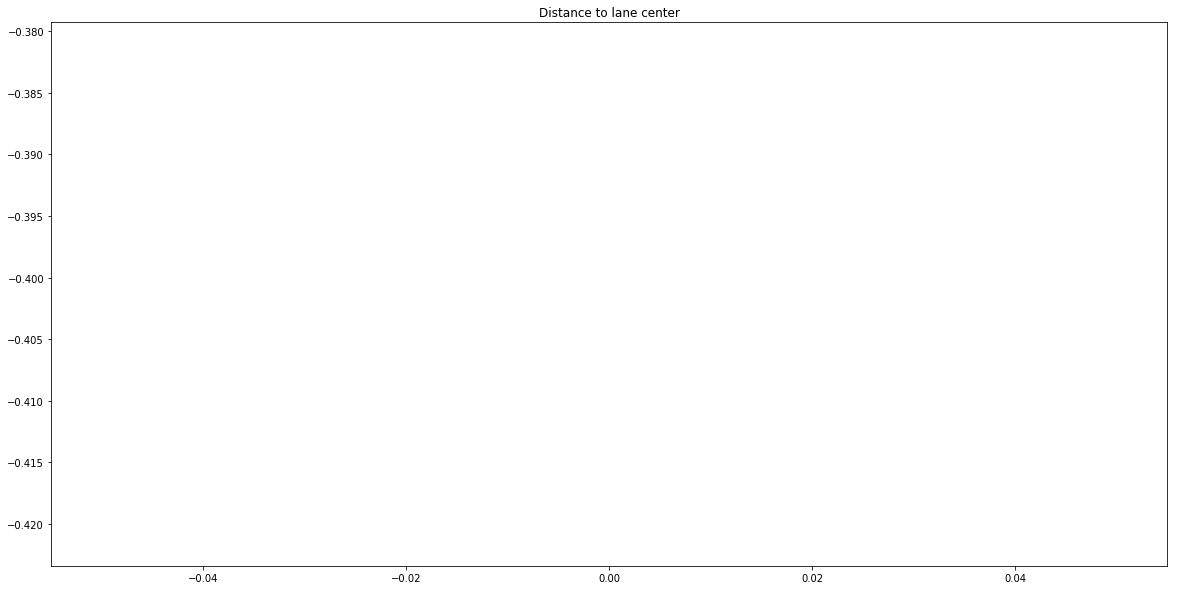

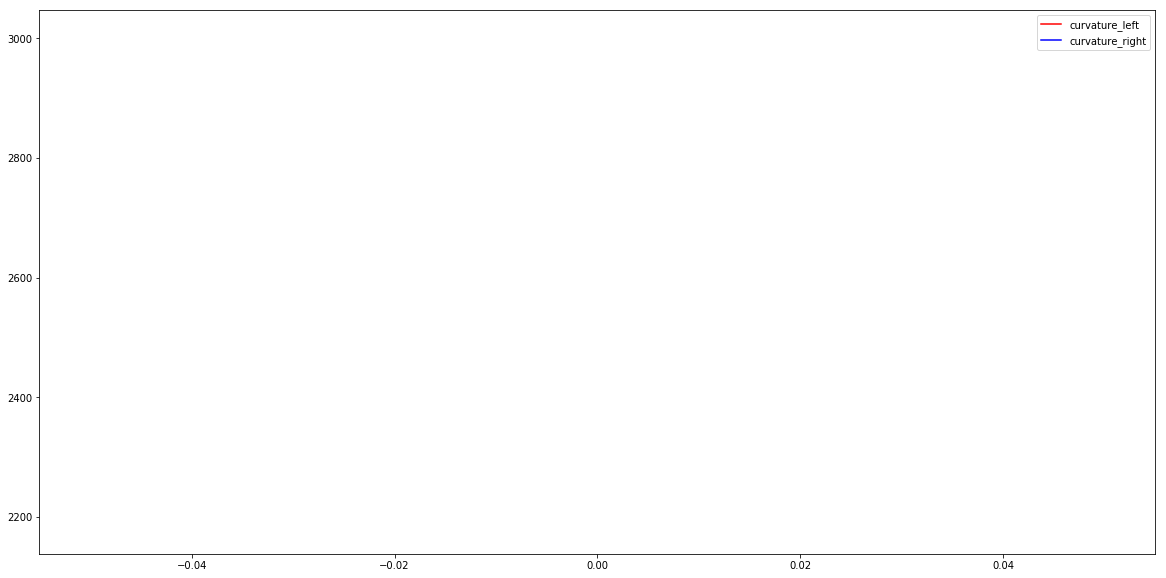

In [70]:
plt.figure(figsize = (20, 10))
plt.plot(myLaneDetector.lane_center_deviation_history)
plt.title('Distance to lane center')
plt.show()
plt.figure(figsize = (20, 10))
plt.plot(myLaneDetector.curvature_left_history, color = 'red', label = 'curvature_left')
plt.plot(myLaneDetector.curvature_right_history, color = 'blue', label = 'curvature_right')
plt.legend()

In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

### Video 2 - challenge_video.mp4

In [80]:
output_path = 'output_videos/challenge_video(output).mp4'
original_clip = VideoFileClip("challenge_video.mp4")
output_clip = original_clip.fl_image(process_image)
%time output_clip.write_videofile(output_path, audio=False, verbose=False, progress_bar=True)



  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:18,  6.20it/s]

  0%|          | 2/485 [00:00<01:31,  5.25it/s]

  1%|          | 3/485 [00:00<01:26,  5.56it/s]

  1%|          | 4/485 [00:00<01:25,  5.63it/s]

  1%|          | 5/485 [00:00<01:25,  5.60it/s]

  1%|          | 6/485 [00:01<01:30,  5.27it/s]

  1%|▏         | 7/485 [00:01<01:34,  5.04it/s]

  2%|▏         | 8/485 [00:01<01:33,  5.07it/s]

  2%|▏         | 9/485 [00:01<01:35,  4.97it/s]

  2%|▏         | 10/485 [00:01<01:33,  5.09it/s]

  2%|▏         | 11/485 [00:02<01:31,  5.16it/s]

  2%|▏         | 12/485 [00:02<01:31,  5.16it/s]

  3%|▎         | 13/485 [00:02<01:30,  5.20it/s]

  3%|▎         | 14/485 [00:02<01:30,  5.19it/s]

  3%|▎         | 15/485 [00:02<01:32,  5.09it/s]

  3%|▎         | 16/485 [00:03<01:33,  5.02it/s]

  4%|▎         | 17/485 [00:03<01:35,  4.92it/s]

  4%|▎         | 18/485 [00:03<01:37,  4.80it/s]

  4%|▍         | 19/485 [00:04<01:39,  4.69it/s]

  4%|▍         |

 30%|██▉       | 145/485 [00:34<01:21,  4.16it/s]

 30%|███       | 146/485 [00:35<01:21,  4.15it/s]

 30%|███       | 147/485 [00:35<01:21,  4.15it/s]

 31%|███       | 148/485 [00:35<01:21,  4.15it/s]

 31%|███       | 149/485 [00:35<01:21,  4.14it/s]

 31%|███       | 150/485 [00:36<01:20,  4.14it/s]

 31%|███       | 151/485 [00:36<01:20,  4.14it/s]

 31%|███▏      | 152/485 [00:36<01:20,  4.14it/s]

 32%|███▏      | 153/485 [00:36<01:20,  4.14it/s]

 32%|███▏      | 154/485 [00:37<01:19,  4.14it/s]

 32%|███▏      | 155/485 [00:37<01:19,  4.14it/s]

 32%|███▏      | 156/485 [00:37<01:19,  4.13it/s]

 32%|███▏      | 157/485 [00:37<01:19,  4.13it/s]

 33%|███▎      | 158/485 [00:38<01:19,  4.13it/s]

 33%|███▎      | 159/485 [00:38<01:18,  4.13it/s]

 33%|███▎      | 160/485 [00:38<01:18,  4.13it/s]

 33%|███▎      | 161/485 [00:38<01:18,  4.13it/s]

 33%|███▎      | 162/485 [00:39<01:18,  4.13it/s]

 34%|███▎      | 163/485 [00:39<01:18,  4.13it/s]

 34%|███▍      | 164/485 [00:39

 59%|█████▉    | 288/485 [01:09<00:47,  4.14it/s]

 60%|█████▉    | 289/485 [01:09<00:47,  4.15it/s]

 60%|█████▉    | 290/485 [01:09<00:47,  4.15it/s]

 60%|██████    | 291/485 [01:10<00:46,  4.15it/s]

 60%|██████    | 292/485 [01:10<00:46,  4.15it/s]

 60%|██████    | 293/485 [01:10<00:46,  4.15it/s]

 61%|██████    | 294/485 [01:10<00:45,  4.16it/s]

 61%|██████    | 295/485 [01:10<00:45,  4.16it/s]

 61%|██████    | 296/485 [01:11<00:45,  4.16it/s]

 61%|██████    | 297/485 [01:11<00:45,  4.16it/s]

 61%|██████▏   | 298/485 [01:11<00:44,  4.17it/s]

 62%|██████▏   | 299/485 [01:11<00:44,  4.17it/s]

 62%|██████▏   | 300/485 [01:11<00:44,  4.17it/s]

 62%|██████▏   | 301/485 [01:12<00:44,  4.18it/s]

 62%|██████▏   | 302/485 [01:12<00:43,  4.18it/s]

 62%|██████▏   | 303/485 [01:12<00:43,  4.18it/s]

 63%|██████▎   | 304/485 [01:12<00:43,  4.19it/s]

 63%|██████▎   | 305/485 [01:12<00:42,  4.19it/s]

 63%|██████▎   | 306/485 [01:12<00:42,  4.20it/s]

 63%|██████▎   | 307/485 [01:13

 89%|████████▉ | 431/485 [01:40<00:12,  4.28it/s]

 89%|████████▉ | 432/485 [01:40<00:12,  4.28it/s]

 89%|████████▉ | 433/485 [01:41<00:12,  4.28it/s]

 89%|████████▉ | 434/485 [01:41<00:11,  4.28it/s]

 90%|████████▉ | 435/485 [01:41<00:11,  4.28it/s]

 90%|████████▉ | 436/485 [01:41<00:11,  4.29it/s]

 90%|█████████ | 437/485 [01:41<00:11,  4.29it/s]

 90%|█████████ | 438/485 [01:42<00:10,  4.29it/s]

 91%|█████████ | 439/485 [01:42<00:10,  4.29it/s]

 91%|█████████ | 440/485 [01:42<00:10,  4.29it/s]

 91%|█████████ | 441/485 [01:42<00:10,  4.29it/s]

 91%|█████████ | 442/485 [01:42<00:10,  4.29it/s]

 91%|█████████▏| 443/485 [01:43<00:09,  4.29it/s]

 92%|█████████▏| 444/485 [01:43<00:09,  4.30it/s]

 92%|█████████▏| 445/485 [01:43<00:09,  4.30it/s]

 92%|█████████▏| 446/485 [01:43<00:09,  4.30it/s]

 92%|█████████▏| 447/485 [01:43<00:08,  4.30it/s]

 92%|█████████▏| 448/485 [01:44<00:08,  4.30it/s]

 93%|█████████▎| 449/485 [01:44<00:08,  4.31it/s]

 93%|█████████▎| 450/485 [01:44

CPU times: user 3min 8s, sys: 7.52 s, total: 3min 15s
Wall time: 1min 52s


In [73]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))
plt.figure()

### Video 3 - harder_challenge_video.mp4

In [ ]:
output_path = 'output_videos/harder_challenge_video(output).mp4'
original_clip = VideoFileClip("harder_challenge_video.mp4")
output_clip = original_clip.fl_image(process_image)
%time output_clip.write_videofile(output_path, audio=False, verbose=False, progress_bar=True)



  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<03:36,  5.54it/s]

  0%|          | 2/1200 [00:00<04:45,  4.20it/s]

  0%|          | 3/1200 [00:00<04:26,  4.49it/s]

  0%|          | 4/1200 [00:00<04:19,  4.61it/s]

  0%|          | 5/1200 [00:01<04:22,  4.54it/s]

  0%|          | 6/1200 [00:01<04:10,  4.76it/s]

  1%|          | 7/1200 [00:01<04:17,  4.63it/s]

  1%|          | 8/1200 [00:01<04:10,  4.76it/s]

  1%|          | 9/1200 [00:01<04:16,  4.65it/s]

  1%|          | 10/1200 [00:02<04:12,  4.71it/s]

  1%|          | 11/1200 [00:02<04:08,  4.79it/s]

  1%|          | 12/1200 [00:02<04:13,  4.69it/s]

  1%|          | 13/1200 [00:02<04:08,  4.77it/s]

  1%|          | 14/1200 [00:02<04:11,  4.71it/s]

  1%|▏         | 15/1200 [00:03<04:09,  4.74it/s]

  1%|▏         | 16/1200 [00:03<04:06,  4.81it/s]

  1%|▏         | 17/1200 [00:03<04:08,  4.76it/s]

  2%|▏         | 18/1200 [00:03<04:07,  4.78it/s]

  2%|▏         | 19/1200 [00:03<04:08,  4.75it/

 12%|█▏        | 143/1200 [00:30<03:42,  4.76it/s]

 12%|█▏        | 144/1200 [00:30<03:41,  4.76it/s]

 12%|█▏        | 145/1200 [00:30<03:41,  4.76it/s]

 12%|█▏        | 146/1200 [00:30<03:41,  4.77it/s]

 12%|█▏        | 147/1200 [00:30<03:40,  4.77it/s]

 12%|█▏        | 148/1200 [00:31<03:40,  4.77it/s]

 12%|█▏        | 149/1200 [00:31<03:39,  4.78it/s]

 12%|█▎        | 150/1200 [00:31<03:39,  4.79it/s]

 13%|█▎        | 151/1200 [00:31<03:38,  4.79it/s]

 13%|█▎        | 152/1200 [00:31<03:38,  4.80it/s]

 13%|█▎        | 153/1200 [00:31<03:38,  4.80it/s]

 13%|█▎        | 154/1200 [00:32<03:37,  4.80it/s]

 13%|█▎        | 155/1200 [00:32<03:37,  4.81it/s]

 13%|█▎        | 156/1200 [00:32<03:36,  4.81it/s]

 13%|█▎        | 157/1200 [00:32<03:36,  4.82it/s]

 13%|█▎        | 158/1200 [00:32<03:36,  4.82it/s]

 13%|█▎        | 159/1200 [00:32<03:35,  4.83it/s]

 13%|█▎        | 160/1200 [00:33<03:35,  4.83it/s]

 13%|█▎        | 161/1200 [00:33<03:34,  4.83it/s]

 14%|█▎     

 24%|██▎       | 284/1200 [01:01<03:17,  4.63it/s]

 24%|██▍       | 285/1200 [01:01<03:17,  4.63it/s]

 24%|██▍       | 286/1200 [01:01<03:17,  4.62it/s]

 24%|██▍       | 287/1200 [01:02<03:17,  4.62it/s]

 24%|██▍       | 288/1200 [01:02<03:17,  4.61it/s]

 24%|██▍       | 289/1200 [01:02<03:17,  4.61it/s]

 24%|██▍       | 290/1200 [01:03<03:17,  4.60it/s]

 24%|██▍       | 291/1200 [01:03<03:17,  4.60it/s]

 24%|██▍       | 292/1200 [01:03<03:17,  4.59it/s]

 24%|██▍       | 293/1200 [01:03<03:17,  4.59it/s]

 24%|██▍       | 294/1200 [01:04<03:17,  4.58it/s]

 25%|██▍       | 295/1200 [01:04<03:17,  4.57it/s]

 25%|██▍       | 296/1200 [01:04<03:18,  4.56it/s]

 25%|██▍       | 297/1200 [01:05<03:18,  4.56it/s]

 25%|██▍       | 298/1200 [01:05<03:18,  4.55it/s]

 25%|██▍       | 299/1200 [01:05<03:18,  4.55it/s]

 25%|██▌       | 300/1200 [01:06<03:18,  4.54it/s]

 25%|██▌       | 301/1200 [01:06<03:18,  4.54it/s]

 25%|██▌       | 302/1200 [01:06<03:18,  4.53it/s]

 25%|██▌    

 35%|███▌      | 425/1200 [01:37<02:57,  4.36it/s]

 36%|███▌      | 426/1200 [01:37<02:57,  4.36it/s]

 36%|███▌      | 427/1200 [01:37<02:57,  4.36it/s]

 36%|███▌      | 428/1200 [01:38<02:57,  4.36it/s]

 36%|███▌      | 429/1200 [01:38<02:57,  4.35it/s]

 36%|███▌      | 430/1200 [01:38<02:56,  4.35it/s]

 36%|███▌      | 431/1200 [01:39<02:56,  4.35it/s]

 36%|███▌      | 432/1200 [01:39<02:56,  4.34it/s]

 36%|███▌      | 433/1200 [01:39<02:56,  4.34it/s]

 36%|███▌      | 434/1200 [01:39<02:56,  4.34it/s]

 36%|███▋      | 435/1200 [01:40<02:56,  4.34it/s]

 36%|███▋      | 436/1200 [01:40<02:56,  4.34it/s]

 36%|███▋      | 437/1200 [01:40<02:56,  4.33it/s]

 36%|███▋      | 438/1200 [01:41<02:56,  4.33it/s]

 37%|███▋      | 439/1200 [01:41<02:55,  4.33it/s]

 37%|███▋      | 440/1200 [01:41<02:55,  4.32it/s]

 37%|███▋      | 441/1200 [01:42<02:55,  4.32it/s]

 37%|███▋      | 442/1200 [01:42<02:55,  4.32it/s]

 37%|███▋      | 443/1200 [01:42<02:55,  4.31it/s]

 37%|███▋   

In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))